<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Building Models for Accuracy vs. Speed

The goal of this notebook is to understand how to train a model with different parameters to achieve either a highly accurate but slow during inference model, or a model with fast inference but lower accuracy.

For example, in IoT settings the inferencing device has limited computational capabilities. This means we need to design our models to have a small memory footprint. In contrast, medical scenarios often require the highest possible accuracy because the cost of mis-classification could impact the well-being of a patient. In this scenario, the accuracy of the model can not be compromised. 

We have conducted various experiments on diverse datasets to find parameters which work well in a wide variety of settings balancing high accuracy or fast inference. In this notebook, we provide these parameters so that your initial models can be trained without any parameter tuning. For most datasets, these parameters are close to optimal. In the second part of the notebook, we provide guidelines on how to fine-tune these parameters based on how they impact the model.

We recommend first training your model with the default parameters, evaluating the results, and then fine-tuning parameters to achieve better results as necessary.

## Table of Contents:
* [Training a High Accuracy, Fast Inference, or Small Size Classifier](#model)
  * [Choosing between two types of models](#choosing)
  * [Pre-processing](#preprocessing)
  * [Training](#training)
  * [Evaluation](#evaluation)
* [Fine tuning our models](#finetuning)
  * [DNN architectures](#dnn)
  * [Key parameters](#key-parameters)
  * [Additional parameters](#other-parameters)
  * [Testing parameters](#testing-parameters)
* [Appendix](#appendix)
  * [Learning rate](#appendix-learning-rate)
  * [Image size](#appendix-imsize)
  * [How we found good parameters](#appendix-good-parameters)

# Training a High Accuracy, Fast Inference, or Small Size Classifier <a name="model"></a>

Let's first verify our fast.ai version:

In [1]:
import fastai
fastai.__version__

'1.0.48'

Ensure edits to libraries are loaded and plotting is shown in the notebook.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import all the functions we need.

In [3]:
import sys
sys.path.append("../../")
import os
from pathlib import Path
import scrapbook as sb

from fastai.metrics import accuracy
from fastai.vision import (
    models, ImageList, imagenet_stats, cnn_learner, get_transforms, open_image, partial
)

from utils_cv.classification.data import Urls, is_data_multilabel
from utils_cv.classification.model import hamming_accuracy, TrainMetricsRecorder
from utils_cv.common.data import unzip_url

Now that we've set up our notebook, let's set the hyperparameters based on which model type was selected.

## Choosing between types of models <a name="choosing"></a>

For most scenarios, computer vision practitioners want to create a high accuracy model, a fast-inference model or a small size model. Set your `MODEL_TYPE` variable to one of the following: `"high_accuracy"`, `"fast_inference"`, or `"small_size"`.

We will use the `FridgeObjects` dataset from a [previous notebook](01_training_introduction.ipynb) again. You can replace the `DATA_PATH` variable with your own data.

When choosing the batch size, remember that even mid-level GPUs run out of memory when training a deeper ResNet model with larger image resolutions. If you get an _out of memory_ error, try reducing the batch size by a factor of 2.

In [4]:
# Choose between "high_accuracy", "fast_inference", or "small_size"
MODEL_TYPE = "fast_inference"

# Path to your data
DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)

# Epochs to train for
EPOCHS_HEAD = 4
EPOCHS_BODY = 12
LEARNING_RATE = 1e-4
BATCH_SIZE = 16 

#Set parameters based on your selected model.
assert MODEL_TYPE in ["high_accuracy", "fast_inference", "small_size"]
if MODEL_TYPE == "high_accuracy":
    ARCHITECTURE = models.resnet50
    IM_SIZE = 500 
    
if MODEL_TYPE == "fast_inference":
    ARCHITECTURE = models.resnet18
    IM_SIZE = 300 

if MODEL_TYPE == "small_size":
    ARCHITECTURE = models.squeezenet1_1
    IM_SIZE = 300 

We'll automatically determine if your dataset is a multi-label or traditional (single-label) classification problem. To do so, we'll use the `is_data_multilabel` helper function. In order to detect whether or not a dataset is multi-label, the helper function will check to see if the datapath contains a csv file that has a column 'labels' where the values are space-delimited. You can inspect the function by calling `is_data_multilabel??`.

This function assumes that your multi-label dataset is structured in the recommended format shown in the [multilabel notebook](02_multilabel_classification.ipynb).

In [5]:
multilabel = is_data_multilabel(DATA_PATH)
metric = accuracy if not multilabel else hamming_accuracy

## Pre-processing <a name="preprocessing"></a>

JPEG decoding represents a performance bottleneck on systems with powerful GPUs which can slow down training significantly. We recommend creating a down-sized copy of the dataset if training takes too long, or if you require multiple training runs to evaluate different parameters. 

The following function will automate image downsizing.
```python
from utils_cv.classification.data import downsize_imagelist

downsize_imagelist(
    im_list = ImageList.from_folder(Path(DATA_PATH)),
    out_dir = "downsized_images", 
    max_dim = IM_SIZE
)
```

Once complete, update the `DATA_PATH` variable to point to `out_dir` so that this notebook uses these resized images. 


## Training <a name="training"></a>

We'll now re-apply the same steps we did in the [01_training_introduction](01_training_introduction.ipynb) notebook here.

Load the data:

In [6]:
label_list = (
    (
        ImageList.from_folder(Path(DATA_PATH))
        .split_by_rand_pct(valid_pct=0.2, seed=10)
        .label_from_folder()
    )
    if not multilabel
    else (
        ImageList.from_csv(Path(DATA_PATH), "labels.csv", folder="images")
        .split_by_rand_pct(valid_pct=0.2, seed=10)
        .label_from_df(label_delim=" ")
    )
)

In [7]:
data = (
    label_list.transform(tfms=get_transforms(), size=IM_SIZE)
    .databunch(bs=BATCH_SIZE)
    .normalize(imagenet_stats)
)

Create the learner.

In [8]:
learn = cnn_learner(data, ARCHITECTURE, metrics=metric, 
                    callback_fns=[partial(TrainMetricsRecorder, show_graph=True)])

Train the last layer for a few epochs.

epoch,train_loss,valid_loss,train_accuracy,valid_accuracy,time
0,1.918930,1.541837,0.166667,0.307692,00:01
1,1.799673,1.415237,0.260417,0.269231,00:01
2,1.709306,1.363579,0.270833,0.346154,00:01
3,1.675465,1.348117,0.322917,0.269231,00:01


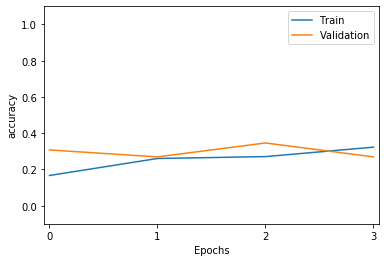

In [9]:
learn.fit_one_cycle(EPOCHS_HEAD, LEARNING_RATE)

Unfreeze the layers.

In [10]:
learn.unfreeze()

Fine-tune the network for the remaining epochs.

epoch,train_loss,valid_loss,train_accuracy,valid_accuracy,time
0,1.633838,1.328570,0.343750,0.423077,00:01
1,1.594517,1.197389,0.281250,0.461538,00:01
2,1.422376,0.945877,0.520833,0.615385,00:01
3,1.231314,0.710786,0.708333,0.730769,00:01
4,1.049589,0.551040,0.822917,0.730769,00:01
5,0.915026,0.468404,0.854167,0.884615,00:01
6,0.814802,0.411285,0.854167,0.884615,00:01
7,0.705605,0.395434,0.947917,0.884615,00:01
8,0.613936,0.374596,0.989583,0.884615,00:01
9,0.543489,0.373512,0.979167,0.923077,00:01


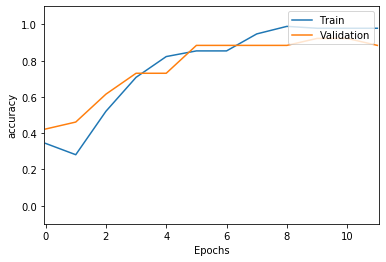

In [11]:
learn.fit_one_cycle(EPOCHS_BODY, LEARNING_RATE)

## Evaluation <a name="evaluation"></a>

In  [01_training introduction](01_training_introduction.ipynb), we demonstrated evaluating a CV model using the performance metrics for precision, recall and ROC. In this section, we will evaluate our model using the following characteristics:
- accuracy (performance)
- inference speed
- parameter export size / memory footprint required

### Performance 
To keep things simple, we just look at the final evaluation metric on the validation set.

In [12]:
_, validation_accuracy = learn.validate(learn.data.valid_dl, metrics=[metric])
print(f"{metric.__name__} on validation set: {float(validation_accuracy):2.2f}")

accuracy on validation set: 0.88


### Inference speed

Time model inference speed.

In [13]:
im_folder = learn.data.classes[0] if not multilabel else 'images'
im = open_image(f"{(Path(DATA_PATH)/im_folder).ls()[0]}")

In [14]:
%%timeit
learn.predict(im)

12.6 ms ± 84 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Memory footprint

Export the model to inspect the size of the model file.

In [15]:
learn.export(f"{MODEL_TYPE}")

In [16]:
size_in_mb = os.path.getsize(Path(DATA_PATH)/MODEL_TYPE) / (1024*1024.)
print(f"'{MODEL_TYPE}' is {round(size_in_mb, 2)}MB.")

'fast_inference' is 44.77MB.


In [17]:
# Preserve some of the notebook outputs
training_accuracies = [x[0].numpy().ravel()[0] for x in learn.recorder.metrics]
sb.glue("training_accuracies", training_accuracies)
sb.glue("validation_accuracy", float(validation_accuracy))

---

# Fine-tuning parameters <a name="finetuning"></a>

If you use the default parameters we have provided, you can get good results across a wide variety of datasets. However, as in most machine learning projects, getting the best possible results for a new dataset often requires tuning the parameters further. The following section provides guidelines on optimizing for accuracy, inference speed, or model size for a given dataset. We'll go through the parameters that will make the largest impact on your model as well as the parameters that may not be worth modifying.

Generally speaking, models for image classification come with a trade-off between training time versus model accuracy. The four parameters that have the biggest impact on this trade-off are the DNN architecture, image resolution, learning rate, and number of epochs. DNN architecture and image resolution will additionally affect the model's inference time and memory footprint. As a rule of thumb, deeper networks with high image resolution will achieve higher accuracy at the cost of large model sizes and low training and inference speeds. Shallow networks with low image resolution will result in models with fast inference speed, fast training speeds and low model sizes at the cost of the model accuracy. 

## DNN architectures <a name="dnn"></a>

When choosing an architecture, we want to make sure it fits our requirements for accuracy, memory footprint, inference speed and training speeds. Some DNNs have hundreds of layers and end up with a large memory footprint and millions of parameters to tune, while others are compact and small enough to fit onto memory limited edge devices. 

Lets take a __squeezenet1_1__ model, a __resnet18__ model and __resnet50__ model and compare these using an experiment over diverse set of 6 datasets. (More about the datasets in the appendix below.)

![architecture_comparisons](media/architecture_comparisons.png)

As you can see from the graph, there is a clear trade-off when deciding between the models. 

In terms of accuracy, __resnet50__ outperforms the rest, but it also suffers from having the highest memory footprint, and the longest training and inference times. Alternatively, __squeezenet1_1__ performs the worst in terms of accuracy, but has the smallest memory footprint.

Generally speaking, given enough data, the deeper DNN and the higher the image resolution, the higher the accuracy you'll be able to achieve with your model.

---

<details><summary>See the code to generate the graphs</summary>
<p>

### Code snippet to generate graphs in this cell
```python
import pandas as pd
from utils_cv.classification.parameter_sweeper import add_value_labels

%matplotlib inline

df = pd.DataFrame(
    {
        "accuracy": [0.9472, 0.9190, 0.8251],
        "training_duration": [385.3, 280.5, 272.5],
        "inference_duration": [34.2, 27.8, 27.6],
        "memory": [99, 45, 4.9],
        "model": ["resnet50", "resnet18", "squeezenet1_1"],
    }
).set_index("model")

ax1, ax2, ax3, ax4 = df.plot.bar(
    rot=90, subplots=True, legend=False, figsize=(8, 10)
)

for ax in [ax1, ax2, ax3, ax4]:
    for i in [0, 1, 2]:
        if i == 0:
            ax.get_children()[i].set_color("r")
        if i == 1:
            ax.get_children()[i].set_color("g")
        if i == 2:
            ax.get_children()[i].set_color("b")

ax1.set_title("Accuracy (%)")
ax2.set_title("Training Duration (seconds)")
ax3.set_title("Inference Time (seconds)")
ax4.set_title("Memory Footprint (mb)")

ax1.set_ylabel("%")
ax2.set_ylabel("seconds")
ax3.set_ylabel("seconds")
ax4.set_ylabel("mb")

ax1.set_ylim(top=df["accuracy"].max() * 1.3)
ax2.set_ylim(top=df["training_duration"].max() * 1.3)
ax3.set_ylim(top=df["inference_duration"].max() * 1.3)
ax4.set_ylim(top=df["memory"].max() * 1.3)

add_value_labels(ax1, percentage=True)
add_value_labels(ax2)
add_value_labels(ax3)
add_value_labels(ax4)
```

</p>
</details>


## Key parameters <a name="key-parameters"></a>
This section examines some of the key parameters when training a deep learning model for image classification. The table below shows default parameters we recommend using.
## Key Parameters <a name="key-parameters"></a>
This section examines some of the key parameters used in training a deep learning model for image classification. The table below shows default parameters:

| Parameter | Default Value |
| --- | --- |
| Learning Rate | 1e-4 |
| Epochs | 15 |
| Batch Size | 16 |
| Image Size | 300 X 300 |

__Learning rate__ 

Learning rate or the step size is used when optimizing your model with gradient descent and tends to be one of the most important parameters to set when training your model. If your learning rate is set too low, training will progress very slowly since we're only making tiny updates to the weights in your network. However, if your learning rate is too high, it can cause undesirable divergent behavior in your loss function. Generally speaking, choosing a learning rate of 1e-4 was shown to work pretty well for most datasets. If you want to reduce training time (by training for fewer epochs), you can try setting the learning rate to 5e-3, but if you notice a spike in the training or validation loss, you may want to try reducing your learning rate.

The learning rate section of [appendix below](#appendix-learning-rate) has more detail.

__Epochs__

An _epoch_ is a full gradient descent iteration cycle across the DNN architecture. Unless your are working with small datasets, using around 15 epochs tends to work well in most cases. When it comes to choosing the number of epochs, a common question is - _Won't too many epochs cause overfitting_? It turns out that the accuracy on the test set typically does not get worse, even if training for too many epochs. Unless your are working with small datasets, using around 15 epochs tends to work pretty well in most cases.


__Batch Size__

Batch size is the number of training samples you use in order to make one update to the model parameters. A batch size of 16 or 32 works well for most cases. Larger batch sizes help speed training time, but at the expense of an increased DNN memory consumption. Depending on your dataset and the GPU you have, you can start with a batch size of 32, and move down to 16 if your GPU doesn't have enough memory. After a certain batch size, improvements to training speed become marginal, hence we found 16 (or 32) to be a good trade-off between training speed and memory consumption. If you reduce the batch size, you may also have to reduce the learning rate.

__Image size__ 

The default image size is __300 X 300__ pixels. Using higher image resolutions can help improve model accuracy but will result in longer training and inference times.

The [appendix below](#appendix-imsize) discussed impact of image resolution in detail.


## Additional parameters <a name="other-parameters"></a>

There are many hyperparameters used to tune DNNs, though in our experience the exact value of these parameters does not have a large impact on model performance, training/inference speed, or memory footprint. 

| Parameter | Good Default Value |
| --- | --- |
| Dropout | 0.5 or (0.5 on the final layer and 0.25 on all previous layers) |
| Weight Decay | 0.01 |
| Momentum | 0.9 or (min=0.85 and max=0.95 when using cyclical momentum) |

__Dropout__

Dropout is used to discard activations at random when training your model. It is a way to keep the model from over-fitting on the training data. In fast.ai, dropout is set to 0.5 by default on the final layer, and 0.25 on all other layer. Unless there is clear evidence of over-fitting, this dropout tends to work well.

__Weight decay (L2 regularization)__

Weight decay is a regularization term applied to help minimize the network loss function. We can think of it as a penalty applied to the weights after an update to prevent the weights from growing too large (the model may not converge if the weights get too large). In fast.ai, the default weight decay is 0.1, which we find to be almost always acceptable. 

__Momentum__

Momentum is a way to accelerate convergence when training a model. Momentum uses a weighted average of the most recent updates applied to the current update. Fast.ai implements cyclical momentum when calling `fit_one_cycle()`, so the momentum will fluctuate over the course of the training cycle. We control this by setting a min and max value for the momentum. 

When using `fit_one_cycle()`, the default values of max=0.95 and min=0.85 are known to work well. If using `fit()`, the default value of 0.9 has been shown to work well. These defaults represent a good trade-off between training speed and the ability of the model to converge to a good solution.

## Testing parameters <a name="testing-parameters"></a>
The `ParameterSweeper` module can be used to search over the parameter space to locate the "best" value for that parameter. See the [exploring hyperparameters notebook](./11_exploring_hyperparameters.ipynb) for more information. 

---

# Appendix <a name="appendix"></a>

## Learning rate <a name="appendix-learning-rate"></a>

Setting a low learning rate requires training for many epochs to reach convergence. However, each additional epoch directly increases the model training time in a linear fashion. To efficiently build a model, it helps to set the learning rate in the correct range. To demonstrate this, we've tested various learning rates on 6 different datasets, training the full network for 3 or 15 epochs.

![lr_comparisons](media/lr_comparisons.png)

<details><summary><em>Understanding the diagram</em></summary>
<p>
    
> The figure on the left shows results of different learning rates on different datasets at 15 epochs. We see that a learning rate of 1e-4 results in the the best overall accuracy for the datasets we have tested. Notice there is a pretty significant variance between the datasets and a learning rate of 1-e3 may work better for some datasets. 
In the figure on the right, at 15 epochs, the results of 1e-4 are only slightly better than that of 1e-3. However, at only 3 epochs, a learning rate of 1e-3 out performs the smaller learning rates. This makes sense since we're limiting the training to only 3 epochs so a model that updates weights more quickly should perform better. Effectively a larger learning rate gets closer to the model convergence. This result indicates higher learning rates (such as 1e-3) may help minimize the training time, and lower learning rates (such as 1e-5) may be better if training time is not constrained. 

</p>
</details>

In both figures, we can see that a learning rate of 1e-3 and 1e-4 tends to workin general. We observe that training with 3 epochs results in lower accuracy compared to 15 epochs. And in some cases, smaller learning rates may prevent the DNN from converging. 

Fast.ai has implemented [one cycle policy with cyclical momentum](https://arxiv.org/abs/1803.09820) which adaptively optimizes the learning rate. This function takes a maximum learning rate value as an argument to help the method avoid the convergence problem. Replace the `fit()` method with `fit_one_cycle()` to use this capability.

---

<details><summary>See the code to generate the graphs</summary>
<p>

### Code snippet to generate graphs in this cell

```python
import matplotlib.pyplot as plt
%matplotlib inline

df_dataset_comp = pd.DataFrame(
    {
        "fashionTexture": [0.8749, 0.8481, 0.2491, 0.670318, 0.1643],
        "flickrLogos32Subset": [0.9069, 0.9064, 0.2179, 0.7175, 0.1073],
        "food101Subset": [0.9294, 0.9127, 0.6891, 0.9090, 0.555827],
        "fridgeObjects": [0.9591, 0.9727, 0.272727, 0.6136, 0.181818],
        "lettuce": [0.8992, 0.9104, 0.632, 0.8192, 0.5120],
        "recycle_v3": [0.9527, 0.9581, 0.766, 0.8591, 0.2876],
        "learning_rate": [0.000100, 0.001000, 0.010000, 0.000010, 0.000001],
    }
).set_index("learning_rate")

df_epoch_comp = pd.DataFrame(
    {
        "3_epochs": [0.823808, 0.846394, 0.393808, 0.455115, 0.229120],
        "15_epochs": [0.920367, 0.918067, 0.471138, 0.764786, 0.301474],
        "learning_rate": [0.000100, 0.001000, 0.010000, 0.000010, 0.000001],
    }
).set_index("learning_rate")

plt.figure(1)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

vals = ax2.get_yticks()

df_dataset_comp.sort_index().plot(kind="bar", rot=0, figsize=(15, 6), ax=ax1)
vals = ax1.get_yticks()
ax1.set_yticklabels(["{:,.2%}".format(x) for x in vals])
ax1.set_ylim(0, 1)
ax1.set_ylabel("Accuracy (%)")
ax1.set_title("Accuracy of Learning Rates by Datasets @ 15 Epochs")
ax1.legend(loc=2)

df_epoch_comp.sort_index().plot(kind="bar", rot=0, figsize=(15, 6), ax=ax2)
ax2.set_yticklabels(["{:,.2%}".format(x) for x in vals])
ax2.set_ylim(0, 1)
ax2.set_title("Accuracy of Learning Rates by Epochs")
ax2.legend(loc=2)
```

</p>
</details>

## Image resolution <a name="appendix-imsize"></a>

A model's input image resolution also impacts model accuracy. Usually, convolutional neural networks are able to take advantage of higher resolution images, especially if the object-of-interest is small in the overall image. But how does image size impact  other model aspects? 

We find that image size doesn't significantly affect the model's memory footprint given the same network architecture, but it has a huge effect on GPU memory. Image size also impacts training and inference speeds.

![imsize_comparisons](media/imsize_comparisons.png)

From the results, we can see that an increase in image resolution from __300 X 300__ to __500 X 500__ will increase the performance marginally at the cost of a longer training duration and slower inference speed.

---

<details><summary>See the code to generate the graphs</summary>
<p>

### Code snippet to generate graphs in this cell

```python
import pandas as pd
from utils_cv.classification.parameter_sweeper import add_value_labels
%matplotlib inline

df = pd.DataFrame(
    {
        "accuracy": [0.9472, 0.9394, 0.9190, 0.9164, 0.8366, 0.8251],
        "training_duration": [385.3, 218.8, 280.5, 184.9, 272.5, 182.3],
        "inference_duration": [34.2, 23.2, 27.8, 17.8, 27.6, 17.3],
        "model": [
            "resnet50 X 499",
            "resnet50 X 299",
            "resnet18 X 499",
            "resnet18 X 299",
            "squeezenet1_1 X 499",
            "squeezenet1_1 X 299",
        ],
    }
).set_index("model")
df

ax1, ax2, ax3 = df.plot.bar(
    rot=90, subplots=True, legend=False, figsize=(12, 12)
)

for i in range(len(df)):
    if i < len(df) / 3:
        ax1.get_children()[i].set_color("r")
        ax2.get_children()[i].set_color("r")
        ax3.get_children()[i].set_color("r")
    if i >= len(df) / 3 and i < 2 * len(df) / 3:
        ax1.get_children()[i].set_color("g")
        ax2.get_children()[i].set_color("g")
        ax3.get_children()[i].set_color("g")
    if i >= 2 * len(df) / 3:
        ax1.get_children()[i].set_color("b")
        ax2.get_children()[i].set_color("b")
        ax3.get_children()[i].set_color("b")

ax1.set_title("Accuracy (%)")
ax2.set_title("Training Duration (seconds)")
ax3.set_title("Inference Speed (seconds)")

ax1.set_ylabel("%")
ax2.set_ylabel("seconds")
ax3.set_ylabel("seconds")

ax1.set_ylim(top=df["accuracy"].max() * 1.2)
ax2.set_ylim(top=df["training_duration"].max() * 1.2)
ax3.set_ylim(top=df["inference_duration"].max() * 1.2)

add_value_labels(ax1, percentage=True)
add_value_labels(ax2)
add_value_labels(ax3)
```

</p>
</details>

## How we found good default parameters <a name="appendix-good-parameters"></a>

We conducted various experiments to explore the impact of different hyperparameters on a model's _accuracy_, _training duration_, _inference speed_, and _memory footprint_. 

### Datasets <a name="datasets"></a>

For our experiments, we relied on a set of six different classification datasets. When selecting these datasets, we wanted to have a variety of image types with different amounts of data and number of classes. 

| Dataset Name | Number of Images | Number of Classes | 
| --- | --- | --- |
| food101Subset | 5000 | 5 | 
| flickrLogos32Subset | 2740 | 33 | 
| fashionTexture | 1716 | 11 | 
| recycle_v3 |  564 | 11 | 
| lettuce | 380 | 2 |
| fridgeObjects | 134 | 4 | 

### Model Characteristics <a name="model-characteristics"></a>

In our experiment, we look at these characteristics to evaluate the impact of various parameters. Here is how we calculated each of the following metrics:

- __Accuracy__ metric is averaged over 5 runs for each dataset. 


- __Training Duration__ metric is the average duration over 5 runs for each dataset.


- __Inference Speed__ is the time it takes the model to run 1000 predictions.


- __Memory Footprint__ is the size of the model pickle file output from the `learn.export(...)` method. 
    